In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import AllChem
import re
import torch
from torch_geometric.data import Data, Batch

from Bio.PDB import PDBList, PDBParser
from Bio import PDB

import networkx as nx
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, GraphConv, GraphSAGE

import random

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

from ydata_profiling import ProfileReport
import os
import math
from scipy.stats import pearsonr

In [2]:
# 固定随机种子等操作
seed = 12345
print('seed is ' + str(seed))
g = torch.Generator()
g.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.use_deterministic_algorithms(True)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。


seed is 12345


# 1. read datasets

In [3]:
raw_data_BindingDB = pd.read_csv('./data/raw_data_Neprilysin_BindingDB.tsv', sep='\t')

raw_data_BindingDB = raw_data_BindingDB[['BindingDB Reactant_set_id','ChEMBL ID of Ligand', 'IC50 (nM)', 'Ligand SMILES']]
raw_data_BindingDB = raw_data_BindingDB.rename(columns= {'ChEMBL ID of Ligand': 'Molecule ChEMBL ID', 'Ligand SMILES':'Smiles'})
raw_data_BindingDB = raw_data_BindingDB.dropna(axis='index', thresh = 2) # if both IC and IC50 are none, delete

raw_data_BindingDB = raw_data_BindingDB.drop_duplicates('Smiles')

raw_data_BindingDB = raw_data_BindingDB.reset_index(drop=True)
raw_data_BindingDB

,BindingDB Reactant_set_id,Molecule ChEMBL ID,IC50 (nM),Smiles
0,50481287,CHEMBL198316,NaN,OC(=O)[C@H]1CCCC2N1C(=O)[C@H](Cc1ccccc21)NC(=O...
1,51527233,NaN,NaN,OC(=O)[C@@H]1CCC[C@H]2N1C(=O)[C@H](Cc1ccccc21)...
2,50071799,CHEMBL78429,NaN,OC(=O)[C@H]1CCCC2N1C(=O)C(Cc1ccccc21)NC(=O)C(S...
3,51527232,NaN,NaN,OC(=O)[C@@H]1CCC[C@H]2N1C(=O)[C@H](Cc1ccccc21)...
4,50478351,CHEMBL63123,NaN,COC(=O)CCNC(=O)C1(CS)CCc2ccccc2C1
...,...,...,...,...
1756,945351,NaN,NaN,CC(C)COC(=O)C(=O)NN(C[C@@H](O)C(O)=O)Cc1ccc(cc...
1757,945352,NaN,NaN,CCOC(=O)C(=O)NN(C[C@@H](O)C(O)=O)Cc1ccc(cc1)-c...
1758,948980,NaN,NaN,O[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...
1759,948981,NaN,NaN,O[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...


In [4]:
raw_data_BindingDB.isna().sum()

BindingDB Reactant_set_id      0
Molecule ChEMBL ID           734
IC50 (nM)                    771
Smiles                         0
dtype: int64

In [5]:
raw_data_BindingDB.nunique()

BindingDB Reactant_set_id    1761
Molecule ChEMBL ID           1027
IC50 (nM)                     421
Smiles                       1761
dtype: int64

In [6]:
raw_data_BindingDB.dtypes

BindingDB Reactant_set_id     int64
Molecule ChEMBL ID           object
IC50 (nM)                    object
Smiles                       object
dtype: object

In [7]:
value_list = []
raw_data_BindingDB_copy = raw_data_BindingDB.copy()

for idx, data in enumerate(raw_data_BindingDB_copy['IC50 (nM)']):
    if type(data) == str:
        if data.startswith('>'):
            value = data.split('>')[1]
            value_list.append(value)
        elif data.startswith('<'):
            value = data.split('<')[1]
            value_list.append(value)
        elif data.startswith('='):
            value = data.split('<')[1]
            value_list.append(value)
        else:
            value_list.append(float(data))
    
    else:
        value_list.append(data)
        
value = pd.Series(value_list, name='IC50 (nM)')

raw_data_BindingDB_copy['IC50 (nM)'] = value
raw_data_BindingDB = raw_data_BindingDB_copy
raw_data_BindingDB

,BindingDB Reactant_set_id,Molecule ChEMBL ID,IC50 (nM),Smiles
0,50481287,CHEMBL198316,NaN,OC(=O)[C@H]1CCCC2N1C(=O)[C@H](Cc1ccccc21)NC(=O...
1,51527233,NaN,NaN,OC(=O)[C@@H]1CCC[C@H]2N1C(=O)[C@H](Cc1ccccc21)...
2,50071799,CHEMBL78429,NaN,OC(=O)[C@H]1CCCC2N1C(=O)C(Cc1ccccc21)NC(=O)C(S...
3,51527232,NaN,NaN,OC(=O)[C@@H]1CCC[C@H]2N1C(=O)[C@H](Cc1ccccc21)...
4,50478351,CHEMBL63123,NaN,COC(=O)CCNC(=O)C1(CS)CCc2ccccc2C1
...,...,...,...,...
1756,945351,NaN,NaN,CC(C)COC(=O)C(=O)NN(C[C@@H](O)C(O)=O)Cc1ccc(cc...
1757,945352,NaN,NaN,CCOC(=O)C(=O)NN(C[C@@H](O)C(O)=O)Cc1ccc(cc1)-c...
1758,948980,NaN,NaN,O[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...
1759,948981,NaN,NaN,O[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...


In [8]:
raw_data_CheMBL = pd.read_csv('./data/raw_data_Neprilysin.csv', sep=';')
raw_data_CheMBL = raw_data_CheMBL[['Molecule ChEMBL ID', 'Standard Value','Smiles' ]]
raw_data_CheMBL = raw_data_CheMBL.rename(columns = {'Standard Value': 'IC50 (nM)'})
raw_data_CheMBL = raw_data_CheMBL.dropna(axis='index', thresh=2)
raw_data_CheMBL = raw_data_CheMBL.drop_duplicates(subset='Smiles')

raw_data_CheMBL = raw_data_CheMBL.reset_index(drop=True)

raw_data_CheMBL

,Molecule ChEMBL ID,IC50 (nM),Smiles
0,CHEMBL276690,0.70,O=P(O)(O)C(Cc1cccc2c1OCO2)N[C@@H](Cc1ccc(-c2cc...
1,CHEMBL431691,10000.00,CC(O)C(NC(=O)C(Cc1ccccc1)CP(=O)(O)[C@H](Cc1ccc...
2,CHEMBL212001,237.00,CCc1nnc(NC(=O)C2(CCC(=O)O)CCCC2)s1
3,CHEMBL27842,10000.00,NC(=O)CC(NC(=O)C(Cc1ccccc1)CP(=O)(O)[C@H](Cc1c...
4,CHEMBL273898,3.50,CC(C)CC(NC(=O)C(CS)C(C)c1ccccc1)C(=O)O
...,...,...,...
469,CHEMBL3221954,79432.82,COC(=O)[C@H](CC(=O)N[C@@H](CO)C(=O)O)CC(C)C
470,CHEMBL4434901,24.00,O=C(O)CCC(=O)N[C@@H](CC(=O)O)Cc1ccc(-c2ccccc2F...
471,CHEMBL4550194,4862.00,CC(=O)Nc1cccc(-c2ccc(C[C@H](CC(=O)O)NC(=O)CCC(...
472,CHEMBL50582,2.60,C[C@H](NC(=O)[C@@H](CS)Cc1ccccc1)C(=O)N1c2cccc...


In [9]:
raw_data_CheMBL.isna().sum()

Molecule ChEMBL ID    0
IC50 (nM)             6
Smiles                0
dtype: int64

In [10]:
raw_data_CheMBL.nunique()

Molecule ChEMBL ID    474
IC50 (nM)             266
Smiles                474
dtype: int64

In [11]:
raw_data_molecule_copy = pd.concat([raw_data_BindingDB, raw_data_CheMBL], axis = 0)

raw_data_molecule_copy = raw_data_molecule_copy.drop_duplicates(subset='Smiles')
raw_data_molecule_copy = raw_data_molecule_copy.reset_index(drop=True)
raw_data_molecule_copy

,BindingDB Reactant_set_id,Molecule ChEMBL ID,IC50 (nM),Smiles
0,50481287.0,CHEMBL198316,NaN,OC(=O)[C@H]1CCCC2N1C(=O)[C@H](Cc1ccccc21)NC(=O...
1,51527233.0,NaN,NaN,OC(=O)[C@@H]1CCC[C@H]2N1C(=O)[C@H](Cc1ccccc21)...
2,50071799.0,CHEMBL78429,NaN,OC(=O)[C@H]1CCCC2N1C(=O)C(Cc1ccccc21)NC(=O)C(S...
3,51527232.0,NaN,NaN,OC(=O)[C@@H]1CCC[C@H]2N1C(=O)[C@H](Cc1ccccc21)...
4,50478351.0,CHEMBL63123,NaN,COC(=O)CCNC(=O)C1(CS)CCc2ccccc2C1
...,...,...,...,...
2226,NaN,CHEMBL3221954,79432.82,COC(=O)[C@H](CC(=O)N[C@@H](CO)C(=O)O)CC(C)C
2227,NaN,CHEMBL4434901,24.0,O=C(O)CCC(=O)N[C@@H](CC(=O)O)Cc1ccc(-c2ccccc2F...
2228,NaN,CHEMBL4550194,4862.0,CC(=O)Nc1cccc(-c2ccc(C[C@H](CC(=O)O)NC(=O)CCC(...
2229,NaN,CHEMBL50582,2.6,C[C@H](NC(=O)[C@@H](CS)Cc1ccccc1)C(=O)N1c2cccc...


In [12]:
raw_data_molecule_copy.isna().sum()

BindingDB Reactant_set_id    470
Molecule ChEMBL ID           734
IC50 (nM)                    777
Smiles                         0
dtype: int64

In [13]:
raw_data_molecule_copy.nunique()

BindingDB Reactant_set_id    1761
Molecule ChEMBL ID           1142
IC50 (nM)                     440
Smiles                       2231
dtype: int64

In [14]:
raw_data_molecule_copy.dtypes

BindingDB Reactant_set_id    float64
Molecule ChEMBL ID            object
IC50 (nM)                     object
Smiles                        object
dtype: object

In [15]:
for idx, row in raw_data_molecule_copy.iterrows():
    flag1 = row['Molecule ChEMBL ID']
    flag2 = row['IC50 (nM)']
    if type(flag1) == float and type(flag2) == float:
        if math.isnan(flag1) and math.isnan(flag2):
            raw_data_molecule_copy = raw_data_molecule_copy.drop(index=idx)

raw_data_molecule_copy = raw_data_molecule_copy.reset_index(drop=True)
raw_data_molecule_copy

,BindingDB Reactant_set_id,Molecule ChEMBL ID,IC50 (nM),Smiles
0,50481287.0,CHEMBL198316,NaN,OC(=O)[C@H]1CCCC2N1C(=O)[C@H](Cc1ccccc21)NC(=O...
1,50071799.0,CHEMBL78429,NaN,OC(=O)[C@H]1CCCC2N1C(=O)C(Cc1ccccc21)NC(=O)C(S...
2,50478351.0,CHEMBL63123,NaN,COC(=O)CCNC(=O)C1(CS)CCc2ccccc2C1
3,51005459.0,CHEMBL271225,NaN,CC(C)C[C@H](S)C(=O)N[C@@H](Cc1ccc(cc1)-c1ccccc...
4,50478360.0,CHEMBL294536,NaN,C[C@H](NC(=O)C1(CS)CCc2ccccc2C1)C(=O)OCc1ccccc1
...,...,...,...,...
1604,NaN,CHEMBL3221954,79432.82,COC(=O)[C@H](CC(=O)N[C@@H](CO)C(=O)O)CC(C)C
1605,NaN,CHEMBL4434901,24.0,O=C(O)CCC(=O)N[C@@H](CC(=O)O)Cc1ccc(-c2ccccc2F...
1606,NaN,CHEMBL4550194,4862.0,CC(=O)Nc1cccc(-c2ccc(C[C@H](CC(=O)O)NC(=O)CCC(...
1607,NaN,CHEMBL50582,2.6,C[C@H](NC(=O)[C@@H](CS)Cc1ccccc1)C(=O)N1c2cccc...


In [16]:
raw_data_molecule_copy.nunique()

BindingDB Reactant_set_id    1139
Molecule ChEMBL ID           1142
IC50 (nM)                     440
Smiles                       1609
dtype: int64

In [17]:
raw_data_molecule_copy.isna().sum()

BindingDB Reactant_set_id    470
Molecule ChEMBL ID           112
IC50 (nM)                    155
Smiles                         0
dtype: int64

In [18]:
raw_data_molecule_copy = raw_data_molecule_copy.dropna(subset='IC50 (nM)')
raw_data_molecule_copy = raw_data_molecule_copy.reset_index(drop = True)

In [19]:
ID_list = []
for idx, row in raw_data_molecule_copy.iterrows():
    flag = row['BindingDB Reactant_set_id']
    # print(type(flag))
    if math.isnan(flag) == True:
        ID_list.append(row['Molecule ChEMBL ID'])
    elif math.isnan(flag) == False:
        ID_list.append(row['BindingDB Reactant_set_id'])

assert(len(ID_list) == raw_data_molecule_copy.shape[0])

ID = pd.Series(ID_list, name='Combined ID')
raw_data_molecule_copy = pd.concat([ID, raw_data_molecule_copy], axis = 1)
raw_data_molecule_copy

,Combined ID,BindingDB Reactant_set_id,Molecule ChEMBL ID,IC50 (nM),Smiles
0,50039359.0,50039359.0,CHEMBL66967,0.03,CC(C)C(C(=O)NO)C(=O)NC(Cc1c[nH]c2ccccc12)C(O)=O
1,599748.0,599748.0,NaN,0.03,C[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...
2,50039369.0,50039369.0,CHEMBL303159,0.03,CC(C)CC(C(=O)NO)C(=O)NC(Cc1c[nH]c2ccccc12)C(O)=O
3,297683.0,297683.0,NaN,0.04,C[C@@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O...
4,599747.0,599747.0,NaN,0.04,C[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...
...,...,...,...,...,...
1449,CHEMBL3221954,NaN,CHEMBL3221954,79432.82,COC(=O)[C@H](CC(=O)N[C@@H](CO)C(=O)O)CC(C)C
1450,CHEMBL4434901,NaN,CHEMBL4434901,24.0,O=C(O)CCC(=O)N[C@@H](CC(=O)O)Cc1ccc(-c2ccccc2F...
1451,CHEMBL4550194,NaN,CHEMBL4550194,4862.0,CC(=O)Nc1cccc(-c2ccc(C[C@H](CC(=O)O)NC(=O)CCC(...
1452,CHEMBL50582,NaN,CHEMBL50582,2.6,C[C@H](NC(=O)[C@@H](CS)Cc1ccccc1)C(=O)N1c2cccc...


In [20]:
change_type = raw_data_molecule_copy['IC50 (nM)'].astype('float32')
raw_data_molecule_copy['IC50 (nM)'] = change_type

In [21]:
raw_data_molecule_copy['pIC50'] = raw_data_molecule_copy['IC50 (nM)'].apply(lambda x: -np.log10(x * 10 ** (-9)))

In [22]:
raw_data_molecule_copy = raw_data_molecule_copy[raw_data_molecule_copy['pIC50'] >= 4.0]

In [23]:
raw_data_molecule = raw_data_molecule_copy.sample(frac=1, random_state=seed)
raw_data_molecule = raw_data_molecule.reset_index(drop=True)
raw_data_molecule

,Combined ID,BindingDB Reactant_set_id,Molecule ChEMBL ID,IC50 (nM),Smiles,pIC50
0,50126640.0,50126640.0,CHEMBL319237,426.0,OC(=O)CN1C(=O)[C@H](CCCC11CCCC1)NC(=O)[C@@H](S...,6.370590
1,50766017.0,50766017.0,CHEMBL555862,14.0,NCCCC[C@@H](NC(=O)C1CCCCCCC(CS)C(=O)N1)C(O)=O,7.853872
2,50859975.0,50859975.0,CHEMBL450935,4.0,CC(C)CN(C[C@H](O)C(O)=O)C(=O)N[C@@H](Cc1ccc2cc...,8.397940
3,50053518.0,50053518.0,CHEMBL296112,27.0,C[C@@H](C[C@@H](Cc1ccc(cc1)-c1ccccc1)NC(=O)CCC...,7.568636
4,50983707.0,50983707.0,CHEMBL66481,16.0,OC(=O)[C@@H]1CCCN2N1C(=O)[C@H](CCC2=O)NC(=O)[C...,7.795880
...,...,...,...,...,...,...
1431,CHEMBL61566,NaN,CHEMBL61566,1490.0,CCCN1CCC[C@H](NC(=O)[C@@H](S)Cc2ccccc2)C(=O)N1...,5.826814
1432,51245631.0,51245631.0,NaN,25.0,OC(=O)CCC(=O)N[C@@H](CC(O)=O)Cc1ccc(cc1)-c1ccccc1,7.602060
1433,50012902.0,50012902.0,CHEMBL346587,2.4,CC(C)CC(CS)C(=O)Nc1cccc(c1)S([O-])(=O)=O,8.619789
1434,CHEMBL208888,NaN,CHEMBL208888,82.0,CCCC(CC1(C(=O)Nc2cn(CC)nn2)CCCC1)C(=O)O,7.086186


In [24]:
del raw_data_molecule['BindingDB Reactant_set_id']
del raw_data_molecule['Molecule ChEMBL ID']

# 2. construct graphs for small molecules

In [25]:
# Define possible values for one-hot encoding
possible_atomic_numbers = list(range(1, 119))
possible_degrees = list(range(0, 10))
possible_hybridizations = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
possible_chirality = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER
]
possible_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
                       Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

possible_bond_stereo = [Chem.rdchem.BondStereo.STEREONONE, Chem.rdchem.BondStereo.STEREOZ,
                        Chem.rdchem.BondStereo.STEREOE, Chem.rdchem.BondStereo.STEREOCIS,
                        Chem.rdchem.BondStereo.STEREOTRANS]

# One-hot encoding functions
def one_hot_encode(value, possible_values):
    encoding = [0] * len(possible_values)
    if value in possible_values:
        encoding[possible_values.index(value)] = 1
    return encoding

# Functions for molecular data processing
def get_atomic_info(atom):
    atomic_number_encoding = one_hot_encode(atom.GetAtomicNum(), possible_atomic_numbers)
    degree_encoding = one_hot_encode(atom.GetTotalDegree(), possible_degrees)
    hybridization_encoding = one_hot_encode(atom.GetHybridization(), possible_hybridizations)
    aromatic_encoding = [1 if atom.GetIsAromatic() else 0]
    implicit_valence_encoding = one_hot_encode(atom.GetImplicitValence(), possible_degrees)
    formal_charge_encoding = [atom.GetFormalCharge()]
    chirality_encoding = one_hot_encode(atom.GetChiralTag(), possible_chirality)

    return atomic_number_encoding + degree_encoding + hybridization_encoding + \
           aromatic_encoding + implicit_valence_encoding + formal_charge_encoding + chirality_encoding

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = [get_atomic_info(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float)

    edges = []
    edge_features = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append((i, j))
        edges.append((j, i))

        bond_type_encoding = one_hot_encode(bond.GetBondType(), possible_bond_types)
        bond_stereo_encoding = one_hot_encode(bond.GetStereo(), possible_bond_stereo)
        conjugation_encoding = [1 if bond.GetIsConjugated() else 0]
        edge_feature = bond_type_encoding + bond_stereo_encoding + conjugation_encoding

        edge_features.append(edge_feature)
        edge_features.append(edge_feature)

    edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [26]:
graph_list = [smiles_to_graph(smile) for smile in raw_data_molecule['Smiles']]
pIC50_list = raw_data_molecule['pIC50'].to_list()

scaler = StandardScaler()
pIC50_list = scaler.fit_transform(np.array(pIC50_list).reshape(-1, 1)).flatten()

for graph, pIC50 in zip(graph_list, pIC50_list):
    graph.y = torch.tensor([pIC50], dtype=torch.float).view(-1, 1)


drug_graphs = graph_list
drug_graphs[0]


Data(x=[28, 149], edge_index=[2, 60], edge_attr=[60, 10], y=[1, 1])

# 3. construct graphs for protein

In [27]:
# Define a mapping from amino acid names to one-hot encoded vectors
amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLU', 'GLN', 'GLY', 'HIS', 'ILE', 
               'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
amino_acid_dict = {aa: idx for idx, aa in enumerate(amino_acids)}

In [28]:
def one_hot_encode_amino_acid(residue_name):
    one_hot = [0] * len(amino_acids)
    if residue_name in amino_acid_dict:
        one_hot[amino_acid_dict[residue_name]] = 1
    return one_hot


def pdb_to_graph(pdb_id):
    pdb_list = PDBList()
    pdb_file_path = pdb_list.retrieve_pdb_file(pdb_id, file_format='pdb', pdir='.')

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file_path)

    # Create a graph
    G = nx.Graph()

    # Traverse through the hierarchy
    for model in structure:
        for chain in model:
            for residue in chain:
                res_id = residue.get_id()
                residue_name = residue.get_resname()
                node_feature = one_hot_encode_amino_acid(residue_name)

                # Additional features: secondary structure and B-factor
                b_factor = residue["CA"].get_bfactor() if 'CA' in residue else 0.0
                
                # Combine all features
                node_feature.append(b_factor)

                G.add_node(res_id, residue_name=residue_name, feature=node_feature)

    # Add edges based on distance threshold
    threshold = 5.0  # Angstroms
    for residue1 in structure.get_residues():
        for residue2 in structure.get_residues():
            if residue1 != residue2:
                try:
                    distance = residue1['CA'] - residue2['CA']  # Using alpha carbon (CA) distance
                    if distance < threshold:
                        G.add_edge(residue1.get_id(), residue2.get_id(), distance=distance)
                except KeyError:
                    continue

    # Convert to PyTorch Geometric Data format
    data = from_networkx(G)

    # Convert node features to tensor and assign to data.x
    node_features = [G.nodes[n]['feature'] for n in G.nodes]
    data.x = torch.tensor(node_features, dtype=torch.float)

    # Optionally add edge attributes if necessary
    edge_attr = [G[u][v]['distance'] for u, v in G.edges]
    data.edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)


    return data

In [29]:
protein_pdb = '1R1J'
protein_graph = pdb_to_graph(protein_pdb)
protein_graph

Structure exists: '.\pdb1r1j.ent' 


Data(edge_index=[2, 1796], residue_name=[789], feature=[789, 21], distance=[1796], num_nodes=789, x=[789, 21], edge_attr=[898, 1])

# 4. datasets preparation

shuffling the dataset before it is split can improve the performance. When downloading the dataset from CheMBL, the compound may be sorted and ranked. 

In [30]:
batch_size = 64
torch.manual_seed(seed)
drug_graph_train_loader = DataLoader(drug_graphs[0: int(len(drug_graphs) * 0.8)], batch_size=batch_size, shuffle=True)
drug_graph_test_loader = DataLoader(drug_graphs[int(len(drug_graphs) * 0.2): ], batch_size=batch_size, shuffle=False)

# 5. model construction

In [31]:
class GCN_Graph(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN_Graph, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)

        x = global_mean_pool(x, batch)  # Global pooling

        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.lin(x)

        return x


class AffinityPredictor(torch.nn.Module):
    def __init__(self, protein_gnn, molecule_gnn, hidden_channels):
        super(AffinityPredictor, self).__init__()
        torch.manual_seed(seed)
        self.protein_gnn = protein_gnn
        self.molecule_gnn = molecule_gnn
        self.lin = torch.nn.Linear(hidden_channels * 2, hidden_channels * 2)
        self.batch = torch.nn.BatchNorm1d(hidden_channels * 2)
        self.fc = torch.nn.Linear(hidden_channels * 2, 1)
    
    def forward(self, protein_data, molecule_data):
        # Protein embedding
        protein_embedding = self.protein_gnn(protein_data.x, protein_data.edge_index, protein_data.batch)
        protein_embedding = protein_embedding.unsqueeze(0).expand(molecule_data.batch.max().item() + 1, -1, -1)  # Expand for batch size
        protein_embedding = protein_embedding.reshape(-1, protein_embedding.size(-1))  # Reshape to match molecule_embedding
        # Molecule embedding
        molecule_embedding = self.molecule_gnn(molecule_data.x, molecule_data.edge_index, molecule_data.batch)
        
        # Concatenate embeddings
        x = torch.cat([protein_embedding, molecule_embedding], dim=1)
        x = self.lin(x)
        x = self.batch(x)
        x = F.leaky_relu(x)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        return self.fc(x)


# 6. initializing the model

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
protein_gnn = GCN_Graph(in_channels=protein_graph.num_node_features, hidden_channels=128, out_channels=128).to(device)
molecule_gnn = GCN_Graph(in_channels=drug_graphs[0].num_node_features, hidden_channels=128, out_channels=128).to(device)
model = AffinityPredictor(protein_gnn, molecule_gnn, hidden_channels=128).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = torch.nn.L1Loss(reduction='mean').to(device)

Using device: cuda


# 7. train and test
rule of thumb: either MAE < 0.6 or R2 > 0.6 is considered as good model
https://www.nature.com/articles/s41598-020-80113-7

In [33]:
def train(model, protein_graph, drug_graph_train_loader, optimizer, criterion, epoch):
    model.train()

    for molecule_data in drug_graph_train_loader:
        
        optimizer.zero_grad()
        molecule_data = molecule_data.to(device)
        protein_graph = protein_graph.to(device)
        
        protein_graph_batch = protein_graph.clone()
        protein_graph_batch.batch = torch.zeros(protein_graph.x.size(0), dtype=torch.long).to(device)
        
        output = model(protein_graph, molecule_data)
        loss = criterion(output, molecule_data.y)
        loss.backward()
        optimizer.step()
    

def test(protein_graph, loader):
    model.eval()

    loss_list = []
    r2_list = []

    with torch.no_grad():
        for data in loader:
            
            protein_graph = protein_graph.to(device)
            data = data.to(device)
            out = model(protein_graph, data)
   
            out = torch.tensor(scaler.inverse_transform(out.detach().cpu().numpy().reshape(-1, 1)).flatten())
            actual = torch.tensor(scaler.inverse_transform(data.y.detach().cpu().numpy().reshape(-1, 1)).flatten())

            mae_loss = criterion(out, actual)

            r2 = r2_score(actual, out)
            r2_list.append(r2)

            mae_loss = mae_loss.detach().cpu().numpy()
            loss_list.append(mae_loss)
            
    return loss_list, r2_list
        
overall_train_r2 = []
overall_test_r2 = []
overall_train_loss = []
overall_test_loss = []

best_loss = float('inf')
patience = 100
patience_counter = 0
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
# Training loop
for epoch in range(1, 2001):
    train(model,protein_graph, drug_graph_train_loader, optimizer, criterion, epoch)

    if epoch % 1 == 0:
        train_loss, r2_train_list = test(protein_graph, drug_graph_train_loader)
        test_loss, r2_test_list = test(protein_graph, drug_graph_test_loader)
        print(f'Epoch {epoch}, MAE train loss: {np.average(train_loss):.4f}, MAE test loss: {np.average(test_loss):.4f}, train r2: {np.average(r2_train_list):.4f}, test r2: {np.average(r2_test_list):.4f}')

        overall_train_loss.append(np.average(train_loss))
        overall_test_loss.append(np.average(test_loss))

        overall_train_r2.append(np.average(r2_train_list))
        overall_test_r2.append(np.average(r2_test_list))


        if np.average(test_loss) < best_loss:
            best_loss = np.average(test_loss)
            patience_counter = 0
            # torch.save(model.state_dict(), 'best_model_no_fingerprint_GraphConv_Combined.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping")
            break
    scheduler.step()

Epoch 1, MAE train loss: 1.2735, MAE test loss: 1.2620, train r2: -0.1186, test r2: -0.1369
Epoch 2, MAE train loss: 1.1139, MAE test loss: 1.0918, train r2: 0.0869, test r2: 0.0891
Epoch 3, MAE train loss: 1.1330, MAE test loss: 1.1290, train r2: 0.1335, test r2: 0.1218
Epoch 4, MAE train loss: 0.9994, MAE test loss: 0.9878, train r2: 0.2920, test r2: 0.2858
Epoch 5, MAE train loss: 0.9792, MAE test loss: 0.9707, train r2: 0.3103, test r2: 0.3025
Epoch 6, MAE train loss: 0.9500, MAE test loss: 0.9431, train r2: 0.3329, test r2: 0.3327
Epoch 7, MAE train loss: 1.1117, MAE test loss: 1.1149, train r2: 0.0670, test r2: 0.0282
Epoch 8, MAE train loss: 1.0541, MAE test loss: 1.0515, train r2: 0.1785, test r2: 0.1387
Epoch 9, MAE train loss: 0.8863, MAE test loss: 0.8804, train r2: 0.4107, test r2: 0.4055
Epoch 10, MAE train loss: 1.0341, MAE test loss: 1.0418, train r2: 0.1977, test r2: 0.1736
Epoch 11, MAE train loss: 0.8268, MAE test loss: 0.8268, train r2: 0.4887, test r2: 0.4791
Epoch 

In [34]:
print('r2 on testset', np.average(overall_test_r2[400:]))
print('MAE on testset',np.average(overall_test_loss[400:]))

r2 on testset 0.8792136230265927
MAE on testset 0.29102382


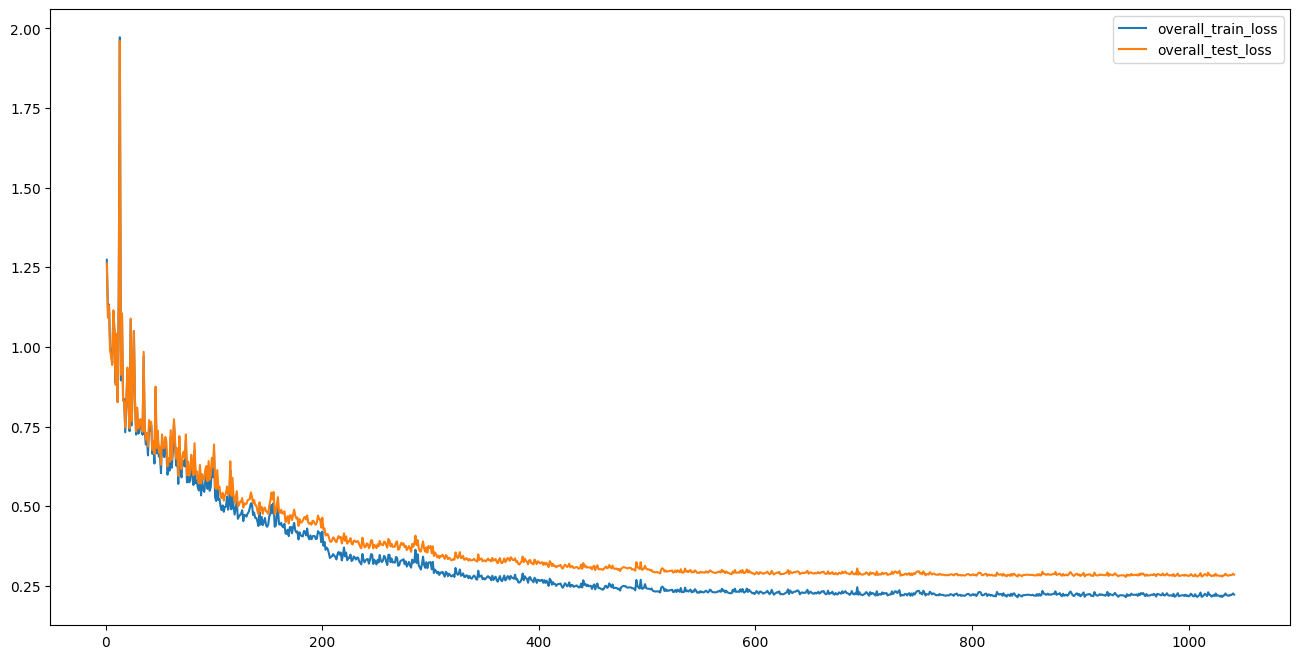

In [35]:
x = [i for i in range(1, 1043)]
fig = plt.figure(figsize=(16, 8))
plt.plot(x, overall_train_loss, label = 'overall_train_loss')
plt.plot(x, overall_test_loss, label = 'overall_test_loss')
plt.legend()
plt.show()
# fig.savefig('./mae_no_fingerprint_GraphConv_Combined.png')

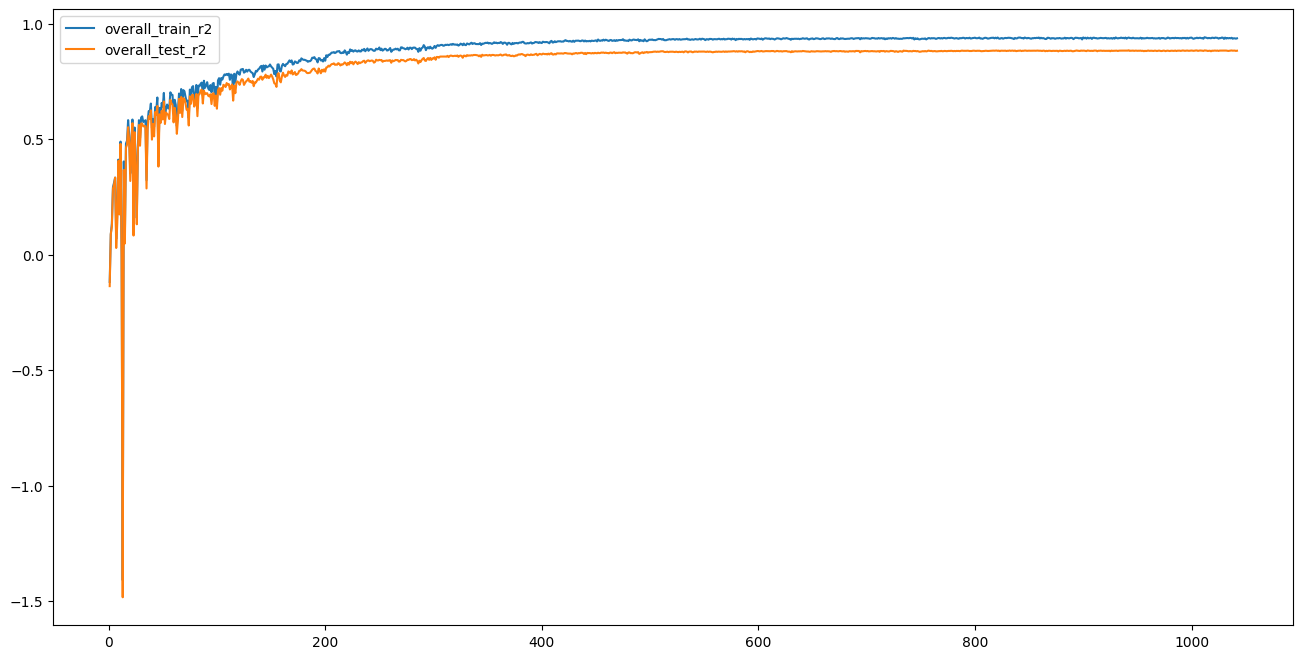

In [36]:
fig = plt.figure(figsize=(16, 8))
plt.plot(x, overall_train_r2, label = 'overall_train_r2')
plt.plot(x, overall_test_r2, label = 'overall_test_r2')
plt.legend()
plt.show()
# fig.savefig('./r2_no_fingerprint_GraphConv_Combined.png')

# 8. Validation on CheMBL dataset

In [37]:
CheMBL = pd.read_csv('./data/raw_data_Neprilysin.csv', sep=';')
CheMBL = CheMBL.sample(frac=1, random_state=seed)
CheMBL

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
56,CHEMBL92949,NaN,NaN,397.37,1.0,1.03,29,CC(C)[C@H](NCP(=O)(O)O)C(=O)N[C@@H](Cc1c[nH]c2...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1150039,1,Scientific Literature,Bioorg Med Chem Lett,1994,NaN,NaN,NaN,NaN
282,CHEMBL37052,NaN,NaN,524.49,1.0,3.14,45,O=C(O)[C@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)[C@H](C...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1131381,1,Scientific Literature,J Med Chem,1998,NaN,NaN,NaN,NaN
289,CHEMBL10247,THIORPHAN,-1.0,253.32,0.0,0.98,DL-thiorphan,O=C(O)CNC(=O)C(CS)Cc1ccccc1,IC50,'=',...,SINGLE PROTEIN,CHEMBL3232818,1,Scientific Literature,Eur J Med Chem,2014,NaN,NaN,NaN,NaN
507,CHEMBL3677665,NaN,NaN,431.49,0.0,4.50,BDBM153112,C[C@H](C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)c1cc...,IC50,'=',...,SINGLE PROTEIN,CHEMBL3638737,37,BindingDB Database,NaN,2015,NaN,NaN,NaN,NaN
240,CHEMBL3695451,NaN,NaN,429.86,0.0,3.31,BDBM138393,C[C@H](N[C@@H](Cc1ccc(-c2cccc(Cl)c2)cc1)C(=O)N...,IC50,'=',...,SINGLE PROTEIN,CHEMBL3638481,37,BindingDB Database,NaN,2014,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,CHEMBL4515703,NaN,NaN,542.15,2.0,6.65,9,CCCCc1nc(Cl)c(CNC(=O)C(CS)CCCC)n1Cc1ccc(-c2ccc...,IC50,'=',...,SINGLE PROTEIN,CHEMBL4308919,1,Scientific Literature,ACS Med Chem Lett,2019,NaN,NaN,NaN,NaN
129,CHEMBL433702,NaN,NaN,349.50,0.0,3.24,42a,O=C1N[C@H](C(=O)O)Cc2ccccc2CCCCCCC[C@@H]1CS,IC50,'=',...,SINGLE PROTEIN,CHEMBL1130406,1,Scientific Literature,J Med Chem,1997,NaN,NaN,NaN,NaN
285,CHEMBL2029397,NaN,NaN,706.81,2.0,-4.25,"6, [Thr4]-Opiorphin",C[C@@H](O)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,IC50,'>',...,SINGLE PROTEIN,CHEMBL2029309,1,Scientific Literature,ACS Med Chem Lett,2012,NaN,NaN,NaN,NaN
485,CHEMBL4451425,NaN,NaN,652.26,2.0,8.36,17,CCCCc1nc(Cl)c(CNC(=O)C(CS)Cc2ccc(-c3ccccc3)cc2...,IC50,'=',...,SINGLE PROTEIN,CHEMBL4308919,1,Scientific Literature,ACS Med Chem Lett,2019,NaN,NaN,NaN,NaN


In [38]:
CheMBL_copy = CheMBL.dropna(subset=['Molecule ChEMBL ID', 'Standard Relation', 'Smiles', 'Standard Value'])
CheMBL_copy = CheMBL_copy.drop_duplicates(subset=['Molecule ChEMBL ID'])
CheMBL_copy = CheMBL_copy[['Molecule ChEMBL ID', 'Standard Relation', 'Smiles', 'Standard Value']].reset_index(drop=True)
# CheMBL_copy = CheMBL_copy[CheMBL_copy['Standard Relation'] == "'='"]
CheMBL_copy

,Molecule ChEMBL ID,Standard Relation,Smiles,Standard Value
0,CHEMBL92949,'=',CC(C)[C@H](NCP(=O)(O)O)C(=O)N[C@@H](Cc1c[nH]c2...,9.00
1,CHEMBL37052,'=',O=C(O)[C@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)[C@H](C...,250.00
2,CHEMBL10247,'=',O=C(O)CNC(=O)C(CS)Cc1ccccc1,1.00
3,CHEMBL3677665,'=',C[C@H](C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)c1cc...,283.00
4,CHEMBL3695451,'=',C[C@H](N[C@@H](Cc1ccc(-c2cccc(Cl)c2)cc1)C(=O)N...,2.40
...,...,...,...,...
463,CHEMBL3695453,'=',O=C(O)[C@H](CCc1ccccc1)N[C@@H](Cc1ccc(-c2cccc(...,0.20
464,CHEMBL198316,'=',O=C(N[C@H]1Cc2ccccc2C2CCC[C@H](C(=O)O)N2C1=O)[...,0.08
465,CHEMBL4515703,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)CCCC)n1Cc1ccc(-c2ccc...,630.96
466,CHEMBL4451425,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)Cc2ccc(-c3ccccc3)cc2...,1995.26


In [39]:
CheMBL_copy.isna().sum()

Molecule ChEMBL ID    0
Standard Relation     0
Smiles                0
Standard Value        0
dtype: int64

In [40]:
CheMBL_copy.nunique()

Molecule ChEMBL ID    468
Standard Relation       3
Smiles                468
Standard Value        264
dtype: int64

In [41]:
pIC50_DB = CheMBL_copy['Standard Value'].apply(lambda x: -np.log10(x * 10 ** (-9) ))
pIC50_DB = pd.Series(pIC50_DB, name='pIC50')
CheMBL_copy['pIC50'] = pIC50_DB
del CheMBL_copy['Standard Value']

In [42]:
CheMBL_copy = CheMBL_copy.reset_index(drop=True)
CheMBL_copy = CheMBL_copy[CheMBL_copy['pIC50'] >= 4.0]
CheMBL_copy = CheMBL_copy.reset_index(drop=True)
CheMBL_copy

,Molecule ChEMBL ID,Standard Relation,Smiles,pIC50
0,CHEMBL92949,'=',CC(C)[C@H](NCP(=O)(O)O)C(=O)N[C@@H](Cc1c[nH]c2...,8.045757
1,CHEMBL37052,'=',O=C(O)[C@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)[C@H](C...,6.602060
2,CHEMBL10247,'=',O=C(O)CNC(=O)C(CS)Cc1ccccc1,9.000000
3,CHEMBL3677665,'=',C[C@H](C[C@@H](Cc1ccc(-c2ccccc2)cc1)NC(=O)c1cc...,6.548214
4,CHEMBL3695451,'=',C[C@H](N[C@@H](Cc1ccc(-c2cccc(Cl)c2)cc1)C(=O)N...,8.619789
...,...,...,...,...
453,CHEMBL3695453,'=',O=C(O)[C@H](CCc1ccccc1)N[C@@H](Cc1ccc(-c2cccc(...,9.698970
454,CHEMBL198316,'=',O=C(N[C@H]1Cc2ccccc2C2CCC[C@H](C(=O)O)N2C1=O)[...,10.096910
455,CHEMBL4515703,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)CCCC)n1Cc1ccc(-c2ccc...,6.199998
456,CHEMBL4451425,'=',CCCCc1nc(Cl)c(CNC(=O)C(CS)Cc2ccc(-c3ccccc3)cc2...,5.700001


In [43]:
def test_DB(protein_graph, loader):
    model.eval()

    loss_list = []
    out_list = []

    with torch.no_grad():
        for data in loader:
            
            protein_graph = protein_graph.to(device)
            data = data.to(device)

            out = model(protein_graph, data)

            out_no_scaled = torch.tensor(scaler.inverse_transform(out.detach().cpu().numpy().reshape(-1, 1)).flatten())
            actual_no_scaled = torch.tensor(scaler.inverse_transform(data.y.detach().cpu().numpy().reshape(-1, 1)).flatten())

            mae_loss = torch.nn.L1Loss(reduction='mean')(out_no_scaled, actual_no_scaled)

            loss_list.append(mae_loss)
            out_list.append(out.detach().cpu().numpy())
            
    return out_list, loss_list

In [55]:
def pred_pIC50(dataframe):

    # dataset preparation
    graph_list = [smiles_to_graph(smile) for smile in dataframe['Smiles']]
    pIC50_list = dataframe['pIC50'].to_list()

    scaler = StandardScaler()
    pIC50_list = scaler.fit_transform(np.array(pIC50_list).reshape(-1, 1)).flatten()

    for graph, pIC50 in zip(graph_list, pIC50_list):
        graph.y = torch.tensor([pIC50], dtype=torch.float).view(-1, 1)

    # data loader
    loader = DataLoader(graph_list, batch_size = 1, shuffle = False)
    out_list, loss_list = test_DB(protein_graph, loader)
    print(f'the length of out_list: {len(out_list)}')
    print(f'the length of out_list: {len(loss_list)}')
    print(f'average MAE loss: {np.average(loss_list):.4f}')

    out_list_modify = []
    for out in out_list:
        out = out[0][0]
        out_list_modify.append(out)
    out_list_modify = np.array(out_list_modify)

    y_pred_array = scaler.inverse_transform(out_list_modify.reshape(-1, 1)).flatten()
    pIC50_pred = pd.Series(y_pred_array, name='pIC50_pred')

    dataframe['pIC50_pred'] = pIC50_pred

    return dataframe

the length of out_list: 458
the length of out_list: 458
average MAE loss: 0.3216


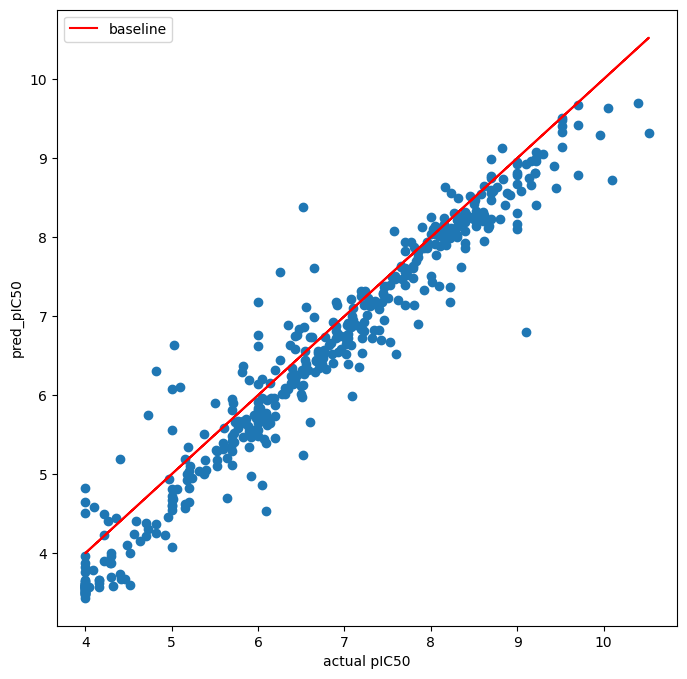

In [56]:
CheMBL_copy = pred_pIC50(CheMBL_copy)
x = CheMBL_copy['pIC50'].to_list()
y = CheMBL_copy['pIC50_pred'].to_list()

y_baseline = x
fig = plt.figure(figsize=(8,8))
plt.scatter(x, y)
plt.plot(x, y_baseline, label = 'baseline', color = 'r')
plt.legend()
plt.xlabel('actual pIC50')
plt.ylabel('pred_pIC50')
plt.show()

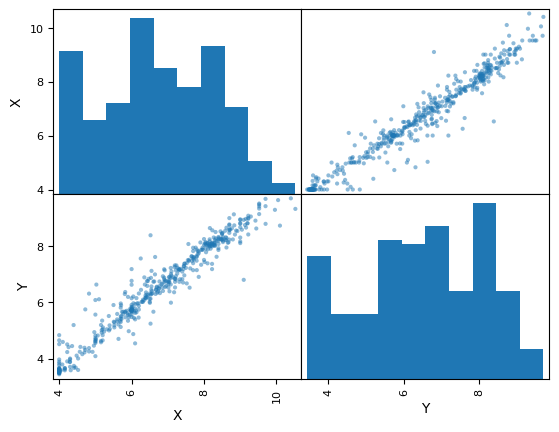

pearson coefficient: 0.9702440550799274
P-Value: 5.13640792651927e-283
0.9193100536412938


In [57]:
pred_results = pd.DataFrame({"X":x,"Y":y})
pd.plotting.scatter_matrix(pred_results)
plt.show()

r = pearsonr(pred_results['X'],pred_results['Y'])
print("pearson coefficient:",r[0])
print("P-Value:",r[1])
print(r2_score(x, y))

# 9. Validation on BindingDB

In [67]:
BindingDB_val = raw_data_BindingDB.dropna(subset='IC50 (nM)')
BindingDB_val = BindingDB_val.reset_index(drop=True)

value_list = []
BindingDB_val_copy = BindingDB_val.copy()

for idx, data in enumerate(BindingDB_val_copy['IC50 (nM)']):
    if type(data) == str:
        if data.startswith('>'):
            value = data.split('>')[1]
            value_list.append(value)
        elif data.startswith('<'):
            value = data.split('<')[1]
            value_list.append(value)
        elif data.startswith('='):
            value = data.split('<')[1]
            value_list.append(value)
        else:
            value_list.append(float(data))
    
    else:
        value_list.append(data)
        
value = pd.Series(value_list, name='IC50 (nM)')

BindingDB_val_copy['IC50 (nM)'] = value
BindingDB_val = BindingDB_val_copy
BindingDB_val

,BindingDB Reactant_set_id,Molecule ChEMBL ID,IC50 (nM),Smiles
0,50039359,CHEMBL66967,0.03,CC(C)C(C(=O)NO)C(=O)NC(Cc1c[nH]c2ccccc12)C(O)=O
1,599748,NaN,0.03,C[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...
2,50039369,CHEMBL303159,0.03,CC(C)CC(C(=O)NO)C(=O)NC(Cc1c[nH]c2ccccc12)C(O)=O
3,297683,NaN,0.04,C[C@@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O...
4,599747,NaN,0.04,C[C@H](C[C@@H](Cc1ccc(cc1)-c1cccc(Cl)c1)NC(=O)...
...,...,...,...,...
985,50152216,CHEMBL88228,214000.00,CC(C)C[C@H](NC(=O)C(CN(O)C(C)=O)Cc1ccccc1)C(=O...
986,50744238,CHEMBL37879,700000.00,CC(C)C[C@H](NC(=O)[C@@H](N)Cc1ccccc1)C(O)=O
987,50152204,CHEMBL315395,705000.00,CC(C)C[C@H](NC(=O)C(CN(O)C(N)=O)Cc1ccccc1)C(=O...
988,50813330,CHEMBL114552,2000000.00,OC(=O)CCCN=CP(O)(O)CCc1ccccc1


In [68]:
change_type = BindingDB_val['IC50 (nM)'].astype('float32')
BindingDB_val['IC50 (nM)'] = change_type

In [69]:
BindingDB_val['pIC50'] = BindingDB_val['IC50 (nM)'].apply(lambda x: -np.log10(x * 10 ** (-9)))
BindingDB_val_copy = BindingDB_val[BindingDB_val['pIC50'] >= 4.0]
BindingDB_val = BindingDB_val_copy.sample(frac=1, random_state=seed)
BindingDB_val = BindingDB_val.reset_index(drop=True)
BindingDB_val

,BindingDB Reactant_set_id,Molecule ChEMBL ID,IC50 (nM),Smiles,pIC50
0,50473841,CHEMBL290792,1000.0,OP(O)(=O)CN[C@@H](Cc1ccc(cc1)-c1ccccc1)c1nnnn1...,6.000000
1,50724123,CHEMBL50312,2.2,C[C@H](NC(=O)[C@@H](CS)Cc1ccccc1Cl)C(=O)N1CCC[...,8.657577
2,50761078,CHEMBL4078112,100000.0,CCC[C@H](N[C@@H](CCc1ccccc1)C(O)=O)C(=O)N1C[C@...,4.000000
3,50053508,CHEMBL295037,90.0,C[C@H](C[C@@H](Cc1ccc(cc1)-c1ccccc1)NC(=O)CCCC...,7.045757
4,50752320,CHEMBL85324,90.0,[O-]C(=O)[C@H](C[C@H](Cc1ccccc1)C(=O)Nc1cccc(c...,7.045757
...,...,...,...,...,...
977,50012929,CHEMBL422165,37.0,CN(C)c1ccc(CC(CS)C(=O)NCCS([O-])(=O)=O)cc1,7.431798
978,50012902,CHEMBL346587,2.4,CC(C)CC(CS)C(=O)Nc1cccc(c1)S([O-])(=O)=O,8.619789
979,50724137,CHEMBL51466,9.4,OC(=O)CCNC(=O)[C@@H](CS)Cc1ccccc1,8.026872
980,50065387,CHEMBL11344,65.0,COc1cc(ccc1O)C(C)C(CS)C(=O)NC(Cc1ccc(O)cc1)C(O)=O,7.187087


the length of out_list: 982
the length of out_list: 982
average MAE loss: 0.3434


<function matplotlib.pyplot.show(close=None, block=None)>

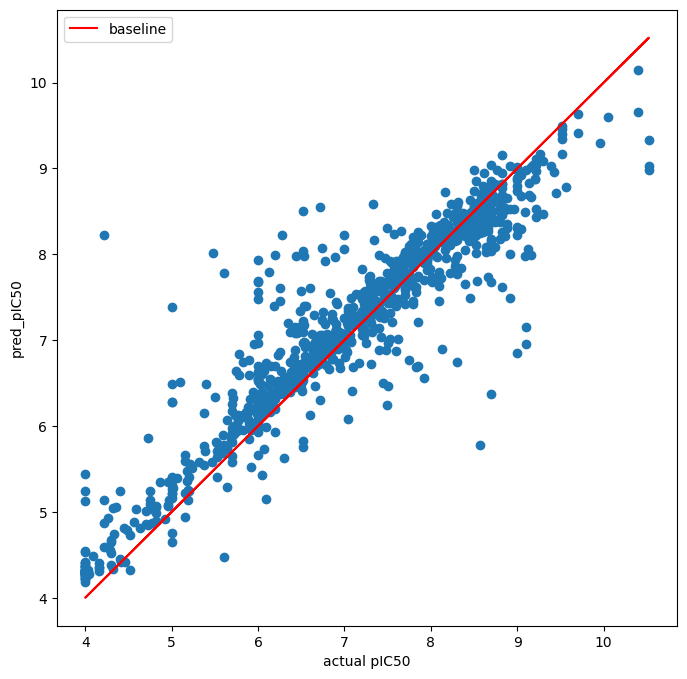

In [73]:
BindingDB_val = pred_pIC50(BindingDB_val)
x_DB = BindingDB_val['pIC50'].to_list()
y_DB = BindingDB_val['pIC50_pred'].to_list()

y_baseline = x_DB
fig = plt.figure(figsize=(8,8))
plt.scatter(x_DB, y_DB)
plt.plot(x_DB, y_baseline, label = 'baseline', color = 'r')
plt.legend()
plt.xlabel('actual pIC50')
plt.ylabel('pred_pIC50')
plt.show

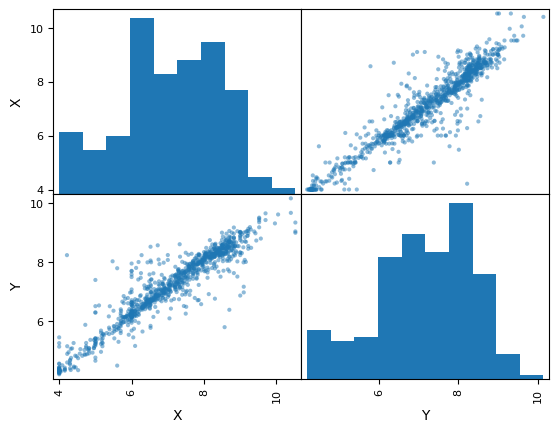

pearson coefficient: 0.9371968287508974
P-Value: 0.0
0.8694058009118317


In [74]:
pred_results_DB = pd.DataFrame({"X":x_DB,"Y":y_DB})
pd.plotting.scatter_matrix(pred_results_DB)
plt.show()

r_DB = pearsonr(x_DB,y_DB)
print("pearson coefficient:", r_DB[0])
print("P-Value:", r_DB[1])
print(r2_score(x_DB, y_DB))